## Goals 🎯

Topinc Modeling permet d'analyser un grand volume de texte par clustering et les clase en sujet (topic)

The project can be cut into three steps :

1. Identify groups of products that have similar descriptions.

2. Use the groups of similar products to build a simple recommender system algorithm.

3. Use topic modeling algorithms to automatically assess the latent topics present in the item descriptions.

In [1]:
import pandas as pd
import numpy as np
import spacy

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

nlp = spacy.load("en_core_web_sm")

In [2]:
data = pd.read_csv("src/North_face_data.csv")
data.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [3]:
data.shape

(500, 2)

In [4]:

print(" Visualization of first element :")

print(' ')
print('Description du 1er produit : ',data.loc[0,'description'])

 Visualization of first element :
 
Description du 1er produit :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Thr

### Preprocessing of textual data

In [5]:
data['clean_documents'] = data['description'].str.replace(r"[^A-Za-z0-9 ]+", " ")
data['clean_documents'] = data['description'].str.replace(r"<[a-z/]+>", " ") 
data['clean_documents'] = data['description'].str.replace(r"<[a-z/]+>", " ") 
data['clean_documents'] = data['clean_documents'].str.replace(r"[^A-Za-z]+", " ") 
data['clean_documents'] = data['clean_documents'].fillna('').apply(lambda x: x.lower())
data['clean_documents'] = data['clean_documents'].str.replace("br", " ")
data['clean_documents'] = data['clean_documents'].str.replace("ul", " ")
data['clean_documents'] = data['clean_documents'].str.replace("li", " ")
data['clean_documents'] = data['clean_documents'].str.replace("<li>"," ")
data['clean_documents'] = data['clean_documents'].str.replace("</li>"," ")
data.head()

,id,description,clean_documents
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer iefs skinning up glory req...
2,3,Active sport briefs - These superbreathable no...,active sport iefs these super eathable no fly...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in c mb ice switch to ...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...


In [6]:

print('Description du 1er produit : ',data.loc[0,'clean_documents'])

Description du 1er produit :  active classic boxers there s a reason why our boxers are a c t favorite they keep their cool especially in sticky situations the quick drying  ghtweight underwear takes up minimal space in a travel pack an exposed  ushed waistband offers next to skin softness five panel construction with a traditional boxer back for a classic fit and a functional fly made of oz recycled polyester with moisture wicking performance inseam size m is recyclable through the common threads recyc ng program details silky capilene fa ic is  tra ght  eathable and quick to dry exposed  ushed elastic waistband for comfort panel construction with traditional boxer back inseam size m is fa ic oz all recycled polyester with gladiodor natural odor control for the garment recyclable through the common threads recyc ng program weight g oz made in mexico 


#### tokenization - lemmalization & stop word

In [7]:
data["clean_documents"] = data["clean_documents"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])
data.head()



,id,description,clean_documents
0,1,Active classic boxers - There's a reason why o...,"[active, classic, boxer, s, reason, boxer, c, ..."
1,2,Active sport boxer briefs - Skinning up Glory ...,"[active, sport, boxer, , ief, skin, glory, re..."
2,3,Active sport briefs - These superbreathable no...,"[active, sport, , ief, super, eathable, fly, ..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","[alpine, guide, pant, skin, c, mb, ice, switch..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","[alpine, wind, jkt, high, ridge, steep, ice, a..."


In [8]:
# on insére les mots dans une colonne nlp_description
data["nlp_description"] = [" ".join(x) for x in data['clean_documents']]
data.head()

,id,description,clean_documents,nlp_description
0,1,Active classic boxers - There's a reason why o...,"[active, classic, boxer, s, reason, boxer, c, ...",active classic boxer s reason boxer c t favori...
1,2,Active sport boxer briefs - Skinning up Glory ...,"[active, sport, boxer, , ief, skin, glory, re...",active sport boxer ief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,"[active, sport, , ief, super, eathable, fly, ...",active sport ief super eathable fly ief mi...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","[alpine, guide, pant, skin, c, mb, ice, switch...",alpine guide pant skin c mb ice switch rock tr...
4,5,"Alpine wind jkt - On high ridges, steep ice an...","[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...


#### TF-IDF vector : term frequency-inverse document frequency 

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(data['nlp_description'])


In [10]:
# densité du tableau

dense = X.toarray()
dense


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
# On obtient une matrice sparse avec de 500 lignes et 3761 colonnes  => 3761 mots

print(X.shape)

(500, 3493)


In [12]:
# dictionnaire d'occurences

vectorizer.vocabulary_

{'active': 21,
 'classic': 469,
 'boxer': 327,
 'reason': 2350,
 'favorite': 1052,
 'cool': 596,
 'especially': 978,
 'sticky': 2838,
 'situation': 2675,
 'quick': 2311,
 'dry': 856,
 'ghtweight': 1249,
 'underwear': 3230,
 'minimal': 1845,
 'space': 2763,
 'travel': 3149,
 'pack': 2066,
 'expose': 1012,
 'ushed': 3279,
 'waistband': 3347,
 'offer': 2000,
 'skin': 2686,
 'softness': 2744,
 'panel': 2085,
 'construction': 572,
 'traditional': 3127,
 'fit': 1103,
 'functional': 1206,
 'fly': 1145,
 'oz': 2063,
 'recycle': 2360,
 'polyester': 2206,
 'moisture': 1871,
 'wicke': 3421,
 'performance': 2138,
 'inseam': 1528,
 'size': 2676,
 'recyclable': 2359,
 'common': 528,
 'thread': 3053,
 'recyc': 2358,
 'ng': 1947,
 'program': 2265,
 'silky': 2658,
 'capilene': 379,
 'fa': 1028,
 'ic': 1458,
 'tra': 3123,
 'ght': 1243,
 'eathable': 896,
 'elastic': 915,
 'comfort': 519,
 'gladiodor': 1258,
 'natural': 1914,
 'odor': 1999,
 'control': 585,
 'garment': 1223,
 'weight': 3398,
 'mexico': 18

### Part 1 : Groups of products with similar descriptions

In [13]:
# Instanciate DBSCAN 
db_cluster = DBSCAN(eps=0.7, min_samples=4, metric="cosine", algorithm="brute")

# Fit on data 
## No need to normalize data, it already is! 
db_cluster.fit(dense)

DBSCAN(algorithm='brute', eps=0.7, metric='cosine', min_samples=4)

In [14]:
dense[:5,:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [15]:
# nb de cluster

#db_cluster.labels_

In [16]:
# pr chaque dezctiption ajout du cluster

data['cluster'] = db_cluster.labels_

data.head()

,id,description,clean_documents,nlp_description,cluster
0,1,Active classic boxers - There's a reason why o...,"[active, classic, boxer, s, reason, boxer, c, ...",active classic boxer s reason boxer c t favori...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,"[active, sport, boxer, , ief, skin, glory, re...",active sport boxer ief skin glory require mo...,0
2,3,Active sport briefs - These superbreathable no...,"[active, sport, , ief, super, eathable, fly, ...",active sport ief super eathable fly ief mi...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...","[alpine, guide, pant, skin, c, mb, ice, switch...",alpine guide pant skin c mb ice switch rock tr...,1
4,5,"Alpine wind jkt - On high ridges, steep ice an...","[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,1


In [17]:
# -1 est du bruit = outlier

data.cluster.value_counts()

 1     208
 0      69
 5      60
-1      39
 2      34
 7      24
 14     12
 3       9
 6       8
 4       8
 10      7
 12      5
 9       5
 13      4
 11      4
 8       4
Name: cluster, dtype: int64

CLUSTER  1


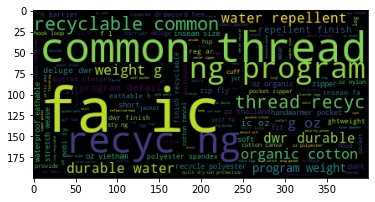

-----------
CLUSTER  0


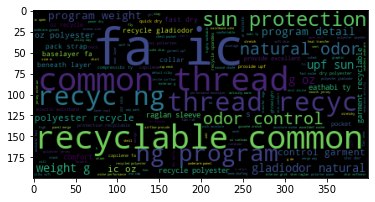

-----------
CLUSTER  5


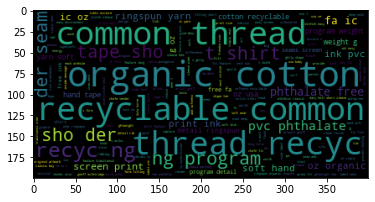

-----------
CLUSTER  -1


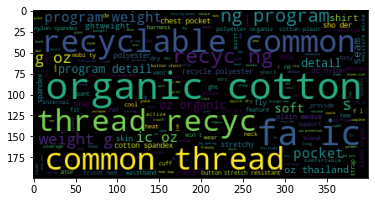

-----------
CLUSTER  2


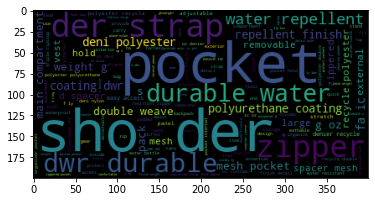

-----------
CLUSTER  7


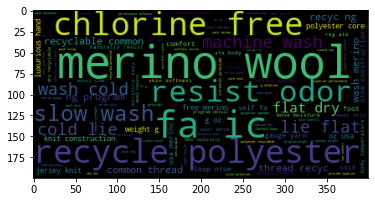

-----------
CLUSTER  14


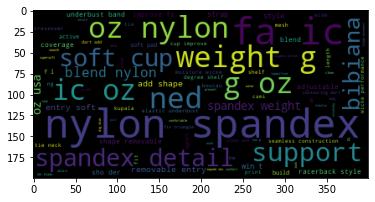

-----------
CLUSTER  3


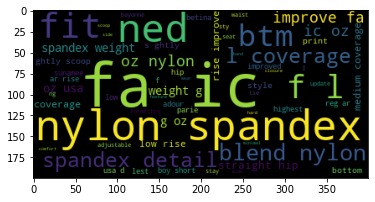

-----------
CLUSTER  6


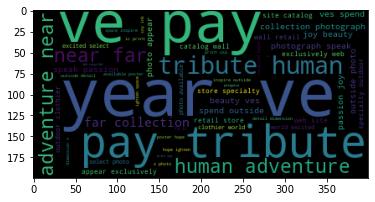

-----------
CLUSTER  4


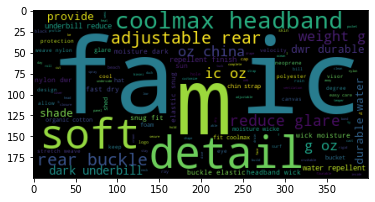

-----------
CLUSTER  10


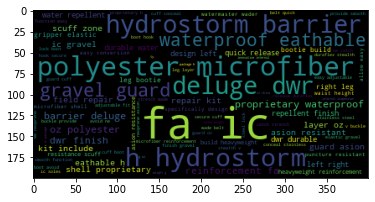

-----------
CLUSTER  12


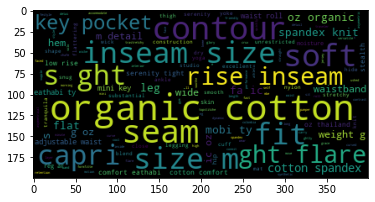

-----------
CLUSTER  9


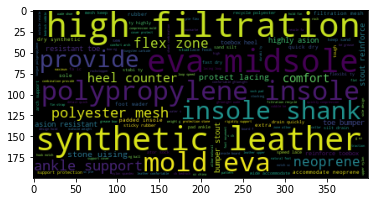

-----------
CLUSTER  13


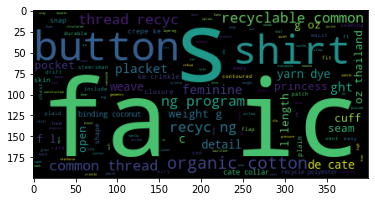

-----------
CLUSTER  11


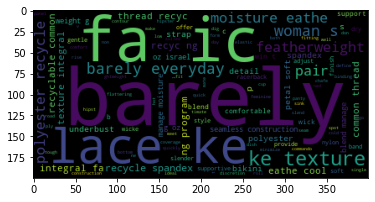

-----------
CLUSTER  8


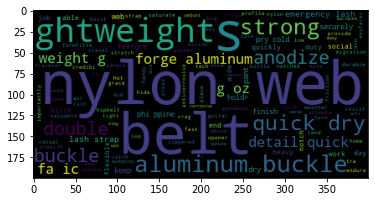

-----------


In [18]:
# Wordcloud pour voir les clusters

wd = wordcloud.WordCloud()
for c in data['cluster'].value_counts().index[:20] :
    print("CLUSTER ", c)
    texts = " ".join(data.loc[data['cluster']==c,'nlp_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

#### Part 2 - Recommender system

🎯

Then, you can use the cluster ids from part 1 to build a recommender system. The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we will consider that products belonging to the same cluster are similar.

Ensuite, vous pouvez utiliser les identifiants de cluster de la partie 1 pour créer un système de recommandation. Le but est de pouvoir proposer à un utilisateur des produits similaires à ceux qui l'intéressent. Pour ce faire, nous considérerons que les produits appartenant à un même cluster sont similaires.

Create a function named find_similar_items that takes an argument item_id representing the id of a product, and that returns a list of 5 item ids that belong to the same cluster as the product passed in argument
Use python's input() function to allow the user to choose a product and perform some suggestions of similar items

In [19]:
def find_similar_product(product_id):
    """
    liste de 5 id de produit qui appartiennent au même cluster
    """
    choose_product = data.loc[data['id']==product_id, 'cluster'].values[0] # choix du produit par l'id
    similar_product = data.loc[data['cluster']==choose_product,:].sample(5) # 5 lignes du dataframes au hasard
    id_similar_product = similar_product['id']
    return id_similar_product
  

In [20]:
pd.set_option('display.max_rows', data.shape[0]+1)
print(data[['id','description']])


      id                                        description
0      1  Active classic boxers - There's a reason why o...
1      2  Active sport boxer briefs - Skinning up Glory ...
2      3  Active sport briefs - These superbreathable no...
3      4  Alpine guide pants - Skin in, climb ice, switc...
4      5  Alpine wind jkt - On high ridges, steep ice an...
5      6  Ascensionist jkt - Our most technical soft she...
6      7  Atom - A multitasker's cloud nine, the Atom pl...
7      8  Print banded betina btm - Our fullest coverage...
8      9  Baby micro d-luxe cardigan - Micro D-Luxe is a...
9     10  Baby sun bucket hat - This hat goes on when th...
10    11  Baby sunshade top - Soft, stretchy polyester f...
11    12  Baggies shorts - Even Baggies, our most popula...
12    13  Beach bucket - Whenever you're at the junction...
13    14  Better sweater jkt - June nights camped out in...
14    15  Borderless shorts-11 in. - Go forward where ot...
15    16  Borderless shorts-7 in. - One 

In [21]:
data[data.id == 12]

,id,description,clean_documents,nlp_description,cluster
11,12,"Baggies shorts - Even Baggies, our most popula...","[baggie, short, baggie, pop, ar, short, occasi...",baggie short baggie pop ar short occasionally ...,1


In [22]:
product_id = int(input("indiquer l'id du produit que vous désirez ? "))
print("")

try:
    choose = find_similar_product(product_id)
except:
    print("Produit non trouvé")
else:
    print('Produit selectionné : ',data.loc[product_id,'nlp_description'])

    print("-------")

    print("")
    print("")
    print("D'aprés l'analyse de vos choix, nous vous proposons 5 produits similaires :")
    print("")

    for i in choose:
        print(data.loc[i,'nlp_description'])
        print("-------")

indiquer l'id du produit que vous désirez ? 12

Produit selectionné :  beach bucket junction water land neutra ze sun s unforgiving ray wide   m soft design versatile beach bucket durable semi rigid foam bill black underneath cast refreshing degree shade oz stretch weave nylon fa ic look feel   ke soft canvas provide water shed fast dry performance detail moisture wicke coolmax headband soft chin strap adjustable rear buckle able bond fa ic oz stretch weave nylon dwr durable water repellent finish detail tough easy care stretch weave nylon   m durable semi rigid foam float bill provide degree sun protection black underbill reduce glare soft chin strap moisture wicke coolmax headband adjustable rear buckle fa ic oz stretch weave nylon dwr durable water repellent finish weight g oz china
-------


D'aprés l'analyse de vos choix, nous vous proposons 5 produits similaires :

astrid tank conjure cardiff s sho dery wave astrid tank unbe evably soft strappy tank flattering scoop neck   ghtest

#### Topic modeling

🎯
This part is independant from the two others.
The aim is to use an LSA model to automatically extract latent topics in the products descriptions.

Cette partie est indépendante des deux autres.
L'objectif est d'utiliser un modèle LSA pour extraire automatiquement les sujets latents dans les descriptions des produits.

In [23]:
# SVD represent documents and terms in vectors 
# la part de chaque description de vêtement dans les topics 

svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = data['nlp_description']
topic_encoded_df.head(2)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,documents
0,0.286891,-0.054957,0.180990,0.103716,-0.108885,0.022818,-0.077514,0.004953,-0.114081,-0.062779,active classic boxer s reason boxer c t favori...
1,0.303534,-0.060572,0.101711,0.104939,-0.025719,0.151240,-0.003045,-0.007314,-0.073241,-0.103838,active sport boxer ief skin glory require mo...


In [24]:
def extract_main_topics(x):
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column `main_topics` with NANs
topic_encoded_df.loc[:, 'main_topic'] = np.nan

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head(2)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,documents,main_topic
0,0.286891,-0.054957,0.180990,0.103716,-0.108885,0.022818,-0.077514,0.004953,-0.114081,-0.062779,active classic boxer s reason boxer c t favori...,topic_0
1,0.303534,-0.060572,0.101711,0.104939,-0.025719,0.151240,-0.003045,-0.007314,-0.073241,-0.103838,active sport boxer ief skin glory require mo...,topic_0


In [25]:
# resultat LSA
topic_encoded_df['main_topic'].value_counts()

topic_0    281
topic_1     61
topic_2     34
topic_6     31
topic_7     30
topic_9     18
topic_3     15
topic_4     14
topic_5      9
topic_8      7
Name: main_topic, dtype: int64

In [26]:
# mots plus fréquents

# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

topics_description.head()

,abandon,abi,able,absolute,absorb,absorption,abstract,abuse,abusive,accentuate,...,zes,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone
topic_0,0.001084,0.002067,0.009001,0.000839,0.001155,0.001277,0.001265,0.005142,0.002083,0.001010,...,0.002564,0.000599,0.085959,0.000873,0.105466,0.043206,0.001351,0.001728,0.001952,0.006753
topic_1,0.000598,0.000794,0.008837,0.000812,0.001675,0.001371,0.003708,0.004136,0.000145,0.000415,...,0.004649,0.000763,0.057419,0.001037,0.122955,0.052006,0.002026,0.002559,0.001906,0.010448
topic_2,0.003461,0.005946,0.005407,0.002265,0.001070,0.000664,0.000392,0.004809,0.000547,0.003633,...,0.001842,0.000764,0.076310,0.000439,0.062342,0.046868,0.001629,0.001823,0.000570,0.000287
topic_3,0.000829,0.000198,0.011294,0.000194,0.003651,0.000205,0.002117,0.000264,0.004286,0.000198,...,0.007612,0.001086,0.078383,0.001063,0.146189,0.038748,0.002858,0.004532,0.002772,0.016324
topic_4,0.004208,0.008511,0.008645,0.001776,0.000603,0.000079,0.000141,0.002091,0.004694,0.004364,...,0.001888,0.000360,0.009875,0.000064,0.007674,0.015332,0.001301,0.000598,0.001760,0.018277


In [27]:
# Loop over each topic and print 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC ', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())

TOPIC  topic_0
['pocket', 'oz', 'organic', 'cotton', 'ng']
TOPIC  topic_1
['organic', 'cotton', 'shirt', 'print', 'ringspun']
TOPIC  topic_2
['merino', 'odor', 'pocket', 'wool', 'control']
TOPIC  topic_3
['inseam', 'organic', 'cotton', 'button', 'zipper']
TOPIC  topic_4
['merino', 'wool', 'wash', 'sun', 'capilene']
TOPIC  topic_5
['nylon', 'fleece', 'sun', 'organic', 'cotton']
TOPIC  topic_6
['spandex', 'coverage', 'tencel', 'pocket', 'inseam']
TOPIC  topic_7
['strap', 'waterproof', 'mesh', 'barrier', 'polyurethane']
TOPIC  topic_8
['sun', 'upf', 'protection', 'fleece', 'collar']
TOPIC  topic_9
['fleece', 'sun', 'waterproof', 'protection', 'barrier']
